In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
import utils2p

In [2]:
raw_path = "/home/jbraun/bin/deepinterpolation/sample_data/longterm_003_crop.tif"
full_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_longterm_003_crop_out.tif"
halves_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_halves_longterm_003_crop_out.tif"
right_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_right_longterm_003_crop_out.tif"
left_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_left_longterm_003_crop_out.tif"
center_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_center_longterm_003_crop_out.tif"
random1_05_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_random1_05_longterm_003_crop_out.tif"
random1_01_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_random1_01_longterm_003_crop_out.tif"
randomlrc_05_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_randomlrc1_05_longterm_003_crop_out.tif"
randomlrc_01_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_randomlrc1_01_longterm_003_crop_out.tif"
multi1_01_path = "/home/jbraun/bin/deepinterpolation/sample_data/denoised_multi_longterm_random1_01_003_crop_out.tif"


raw = utils2p.load_img(raw_path)[30:-30,:,:]
full = utils2p.load_img(full_path)
halves = utils2p.load_img(halves_path)
left = utils2p.load_img(left_path)
right = utils2p.load_img(right_path)
center = utils2p.load_img(center_path)
random1_05 = utils2p.load_img(random1_05_path)
random1_01 = utils2p.load_img(random1_01_path)
randomlrc_05 = utils2p.load_img(randomlrc_05_path)
randomlrc_01 = utils2p.load_img(randomlrc_01_path)
multi1_01 = utils2p.load_img(multi1_01_path)

# compute dff

In [3]:
from scipy.ndimage import gaussian_filter


import nely_suite

In [8]:
stack = random1_01  # randomlrc_01

In [5]:
def compute_dff_from_stack(stack, baseline_blur=3, baseline_mode="convolve", # slow alternative: "quantile"
                           baseline_length=10, baseline_quantile=0.05, baseline_dir=None,
                           use_crop=True, manual_add_to_crop=20,
                           dff_blur=0, dff_out_dir=None, return_stack=True):
    N_frames, N_y, N_x = stack.shape

    # 1. blur stack if required
    stack_blurred = gaussian_filter(stack, (0, baseline_blur, baseline_blur)) if baseline_blur else stack
    
    # 2. compute baseline
    if baseline_mode == "convolve":
        dff_baseline = nely_suite.find_pixel_wise_baseline(stack_blurred, n=baseline_length)
    elif baseline_mode == "quantile":
        dff_baseline = nely_suite.quantile_baseline(stack_blurred, baseline_quantile)
    elif isinstance(baseline_mode, np.ndarray) and baseline_mode.shape == (N_y, N_x):
        dff_baseline = baseline_mode
    elif baseline_mode == "fromfile":
        dff_baseline = nely_suite.load_img(baseline_dir)
        assert dff_baseline.shape == (N_y, N_x)
    else:
        raise(NotImplementedError)

    if baseline_dir is not None and baseline_mode != "fromfile":
        nely_suite.save_img(baseline_dir, dff_baseline)
        
    # 3. compute cropping indices or use the ones supplied externally
    if (isinstance(use_crop, list) or isinstance(use_crop, tuple)) and len(use_crop) == 4:
        x_min, x_max, y_min, y_max = use_crop
    elif isinstance(use_crop, bool) and use_crop:
        mask = nely_suite.analysis.background_mask(stack_blurred, z_projection="std", threshold="otsu")
        idx = np.where(mask)
        y_min = np.maximum(np.min(idx[0]) - manual_add_to_crop, 0)
        y_max = np.minimum(np.max(idx[0]) + manual_add_to_crop, stack_blurred.shape[1] - 1)
        x_min = np.maximum(np.min(idx[1]) - manual_add_to_crop, 0)
        x_max = np.minimum(np.max(idx[1]) + manual_add_to_crop, stack_blurred.shape[2] - 1)
    else:
        x_min = 0
        x_max = N_x - 1
        y_min = 0
        y_max = N_y - 1
    
    #4. apply cropping
    stack = nely_suite.crop_stack(stack, x_min, x_max, y_min, y_max)
    stack_blurred = nely_suite.crop_stack(stack_blurred, x_min, x_max, y_min, y_max)
    dff_baseline = dff_baseline[y_min : y_max + 1, x_min : x_max + 1]
    
    # 5. compute dff
    # this also applies a median filter with (3,3,3) kernel 
    # and ignores the areas set to 0 by motion correction
    dff = nely_suite.calculate_dff(stack,
                                   dff_baseline, 
                                   apply_filter=True, occlusion_handling=True)
    
    # 6. post-process dff
    dff = gaussian_filter(dff, (0, dff_blur, dff_blur)) if dff_blur else dff

    if dff_out_dir is not None:
        nely_suite.save_img(dff_out_dir, dff)

    if return_stack:
        return dff
    else:
        return None

In [9]:
dff_baseline = nely_suite.find_pixel_wise_baseline(stack, n=10)

In [47]:
dff_baseline_filt = gaussian_filter(medfilt(dff_baseline, [3,3]), sigma=(1,1))

<IPython.core.display.Javascript object>


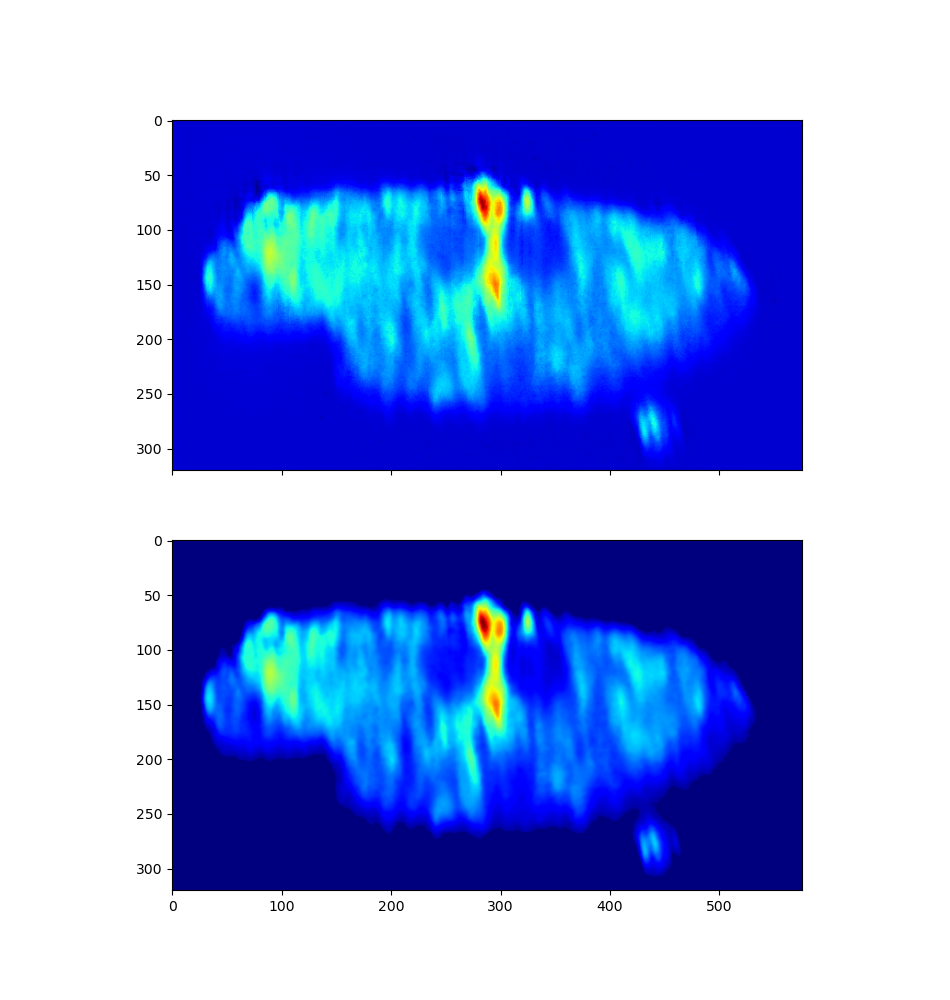

In [59]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9.5, 10), sharex=True, sharey=True)
axs[0].imshow(dff_baseline, cmap=plt.cm.jet)
axs[1].imshow(dff_baseline_filt, cmap=plt.cm.jet)

<IPython.core.display.Javascript object>


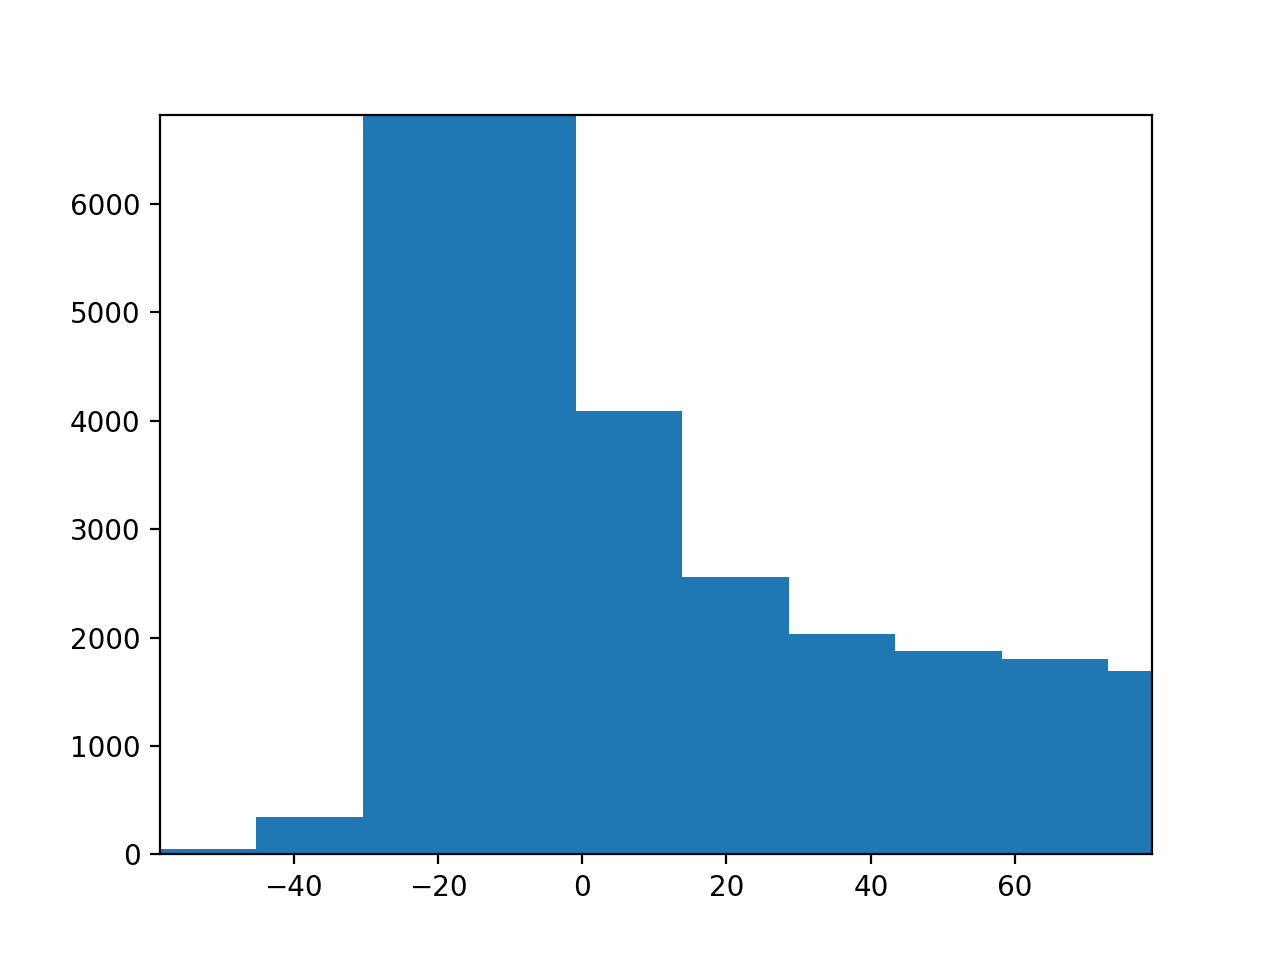

In [49]:
%matplotlib notebook
_ = plt.hist(dff_baseline_filt.flatten(), bins=100)

In [55]:
dff_baseline_filt[dff_baseline_filt<=40] = 0  # 20

In [12]:
dff = nely_suite.calculate_dff(stack, dff_baseline, apply_filter=True, occlusion_handling=True)

In [56]:
dff_bfilt = nely_suite.calculate_dff(stack[:501], dff_baseline_filt, apply_filter=True, occlusion_handling=True)

In [52]:
# dff_bfilt[dff_bfilt<-20] = 0

In [ ]:
dff_sfilt = nely_suite.calculate_dff(stack_filt, dff_baseline, apply_filter=True, occlusion_handling=True)

<IPython.core.display.Javascript object>


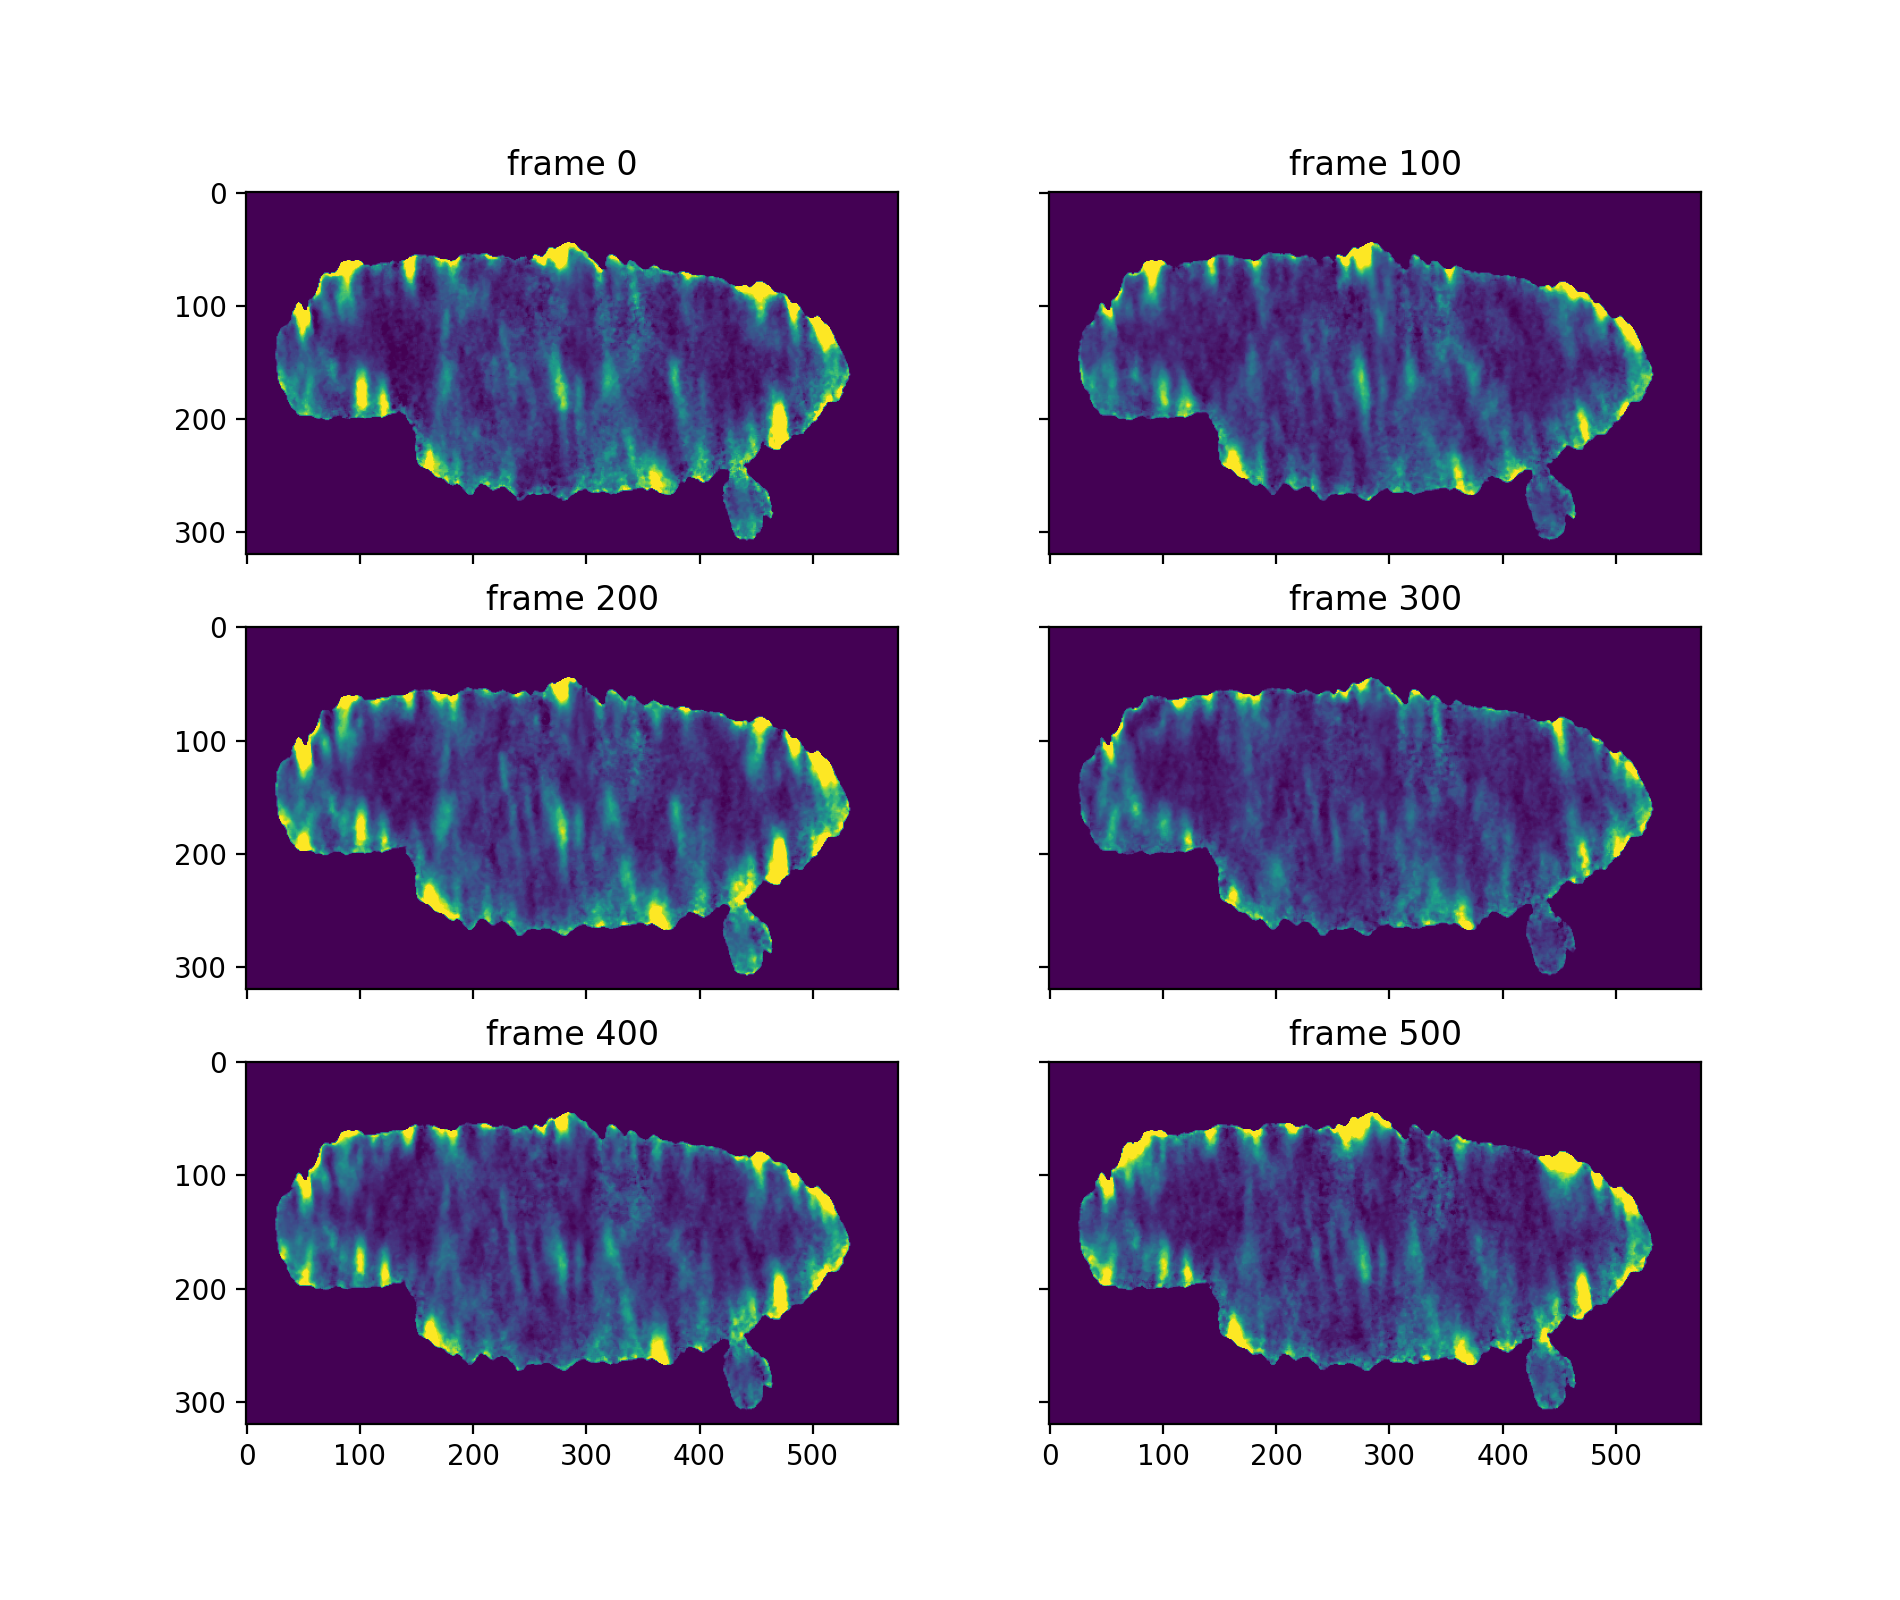

In [58]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9.5, 8), sharex=True, sharey=True)
for i_ax, ax in enumerate(axs.flatten()):
    ax.imshow(dff_bfilt[i_ax*100], clim=[0, np.quantile(dff_bfilt, 0.99)])
    ax.set_title("frame {}".format(i_ax*100))

In [71]:
import os, sys
NOTEBOOKS_PATH = os.getcwd()
MODULE_PATH, _ = os.path.split(NOTEBOOKS_PATH)
sys.path.append(MODULE_PATH)

In [81]:
import cv2, math
import utils_video
from utils_video.utils import resize_shape, colorbar, add_colorbar

In [82]:
def generator_dff(stack, size=None, font_size=16, vmin=None, vmax=None):
    # copied and modified from utils_video to allow external definition of vmin and vmax
    vmin = np.percentile(stack, 0.5) if vmin is None else vmin
    vmax = np.percentile(stack, 99.5) if vmax is None else vmax
    norm = plt.Normalize(vmin, vmax)
    cmap = plt.cm.jet

    if size is None:
        image_shape = stack.shape[1:3]
        cbar_shape = (stack.shape[1], max(math.ceil(stack.shape[2] * 0.1), 150))
    else:
        cbar_width = max(math.ceil(size[1] * 0.1), 150)
        image_shape = (size[0], size[1] - cbar_width)
        image_shape = resize_shape(image_shape, stack.shape[1:3])
        cbar_shape = (image_shape[0], cbar_width)

    cbar = colorbar(norm, cmap, cbar_shape, font_size=font_size)

    def frame_generator():
        for frame in stack:
            frame = cmap(norm(frame))
            frame = (frame * 255).astype(np.uint8)
            frame = cv2.resize(frame, image_shape[::-1])
            frame = add_colorbar(frame, cbar, "right")
            yield frame

    return frame_generator()

def make_video_dff(dff, out_dir, video_name, frames=None, frame_rate=None, trial_dir=None,
                   vmin=None, vmax=None):
    if frames is None:
        frames = np.arange(dff.shape[0])
    else:
        assert np.sum(frames >= dff.shape[0]) == 0
        dff = dff[frames, :, :]


    if frame_rate is None and not trial_dir is None:
        meta_data = utils2p.Metadata(utils2p.find_metadata_file(trial_dir))
        frame_rate = meta_data.get_frame_rate()
    elif frame_rate is None:
        raise NotImplementedError

    if not video_name.endswith(".mp4"):
        video_name = video_name + ".mp4"

    generator = generator_dff(dff, vmin=vmin, vmax=vmax)
    utils_video.make_video(os.path.join(out_dir, video_name), generator, frame_rate)

<IPython.core.display.Javascript object>


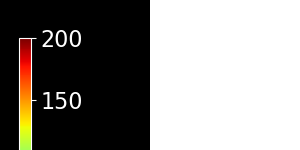

501it [00:03, 159.31it/s]


In [87]:
make_video_dff(dff_bfilt, out_dir="/home/jbraun/tmp/denoise", video_name="dff_denoised", frame_rate=8.1,
              vmin=0, vmax=200)